In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict, Counter
import numpy as np
import itertools
import copy
import matplotlib.pyplot as plt
import random
import json
from dataraw_sampling import *
import itertools
import operator as op
from functools import reduce

In [109]:
def sample_queries(
    num_attributes, num_attr_vals, query_length_multiplier, nest_depth_int, multiple_OR_sets_bool, 
    expression_resolve_fn,
    N_train, N_val, N_test,
    debug=False):
    '''
    query_length_multiplier: int. 0 would sample the multiplier from 1 to 5.
    '''
    
    num_keys = num_attr_vals ** num_attributes
    
    N = N_train + N_val + N_test
    key_datapoints = []
    tokens = []
    gt_idxs = []
    
    buckets = {}
    or_ops = {}
    and_ops = {}
    depths = {}
    input_lens = {}
    
    bucket_probs = derive_shatter_bucket_probs(num_keys)
    cardpair_answer_lookup = construct_cardpair_answer_lookup(num_attributes, num_attr_vals)
    base_vocab_size = num_attributes * num_attr_vals
    symbol_vocab_token_lookup = {
        '(': base_vocab_size,
        ')': base_vocab_size + 1,
        'NULL': base_vocab_size + 2,
        'SEP': base_vocab_size + 3,
        'SOS': base_vocab_size + 4,
        'EOS': base_vocab_size + 5,
        'PAD': base_vocab_size + 6,
        'PLH': base_vocab_size + 7,
        '&': base_vocab_size + 8,
        '|': base_vocab_size + 9,
    }
    
    max_len_q = 0
    for _ in range(N):
        # each query column hit a number of keys
        gt_ks_idx, bucket = sample_keys_column(num_attributes, num_attr_vals, bucket_probs)
        
        # draw one key from this column of keys
        k_idx = np.random.choice(gt_ks_idx)
        
        # determine number of cards in query
        num_cards_per_query = (
            num_keys * (query_length_multiplier if query_length_multiplier else np.random.choice(a==[1,2,3,4,5]))
        )
        
        # sample a query for this column of keys
        q_tokens, num_or_ops, num_and_ops, depth = sample_query_based_on_gt_keys(
            num_attributes=num_attributes, 
            num_attr_vals=num_attr_vals, 
            num_cards_per_query=num_cards_per_query, 
            nest_depth_int=nest_depth_int, 
            gt_keys_idx=gt_ks_idx, 
            multiple_OR_sets_bool=multiple_OR_sets_bool,
            expression_resolve_fn=expression_resolve_fn,
            cardpair_answer_lookup=cardpair_answer_lookup,
            symbol_vocab_token_lookup=symbol_vocab_token_lookup,
            debug=debug
        )
        
        # accumulate datapoints
        k_tokens = decode_key_to_vocab_token(num_attributes, num_attr_vals, k_idx) # check type
        tokens.append((q_tokens, k_tokens))
        key_datapoints.append(k_idx)
        gt_idxs.append(gt_ks_idx)
        
        # stats
        max_len_q = max(max_len_q, len(q_tokens))
        input_lens[len(q_tokens)] = input_lens.get(len(q_tokens), 0) + 1
        buckets[bucket] = buckets.get(bucket, 0) + 1
        or_ops[num_or_ops] = or_ops.get(num_or_ops, 0) + 1
        and_ops[num_and_ops] = and_ops.get(num_and_ops, 0) + 1
        depths[depth] = depths.get(depth, 0) + 1
    
    data = {
        'num_attributes':num_attributes,
        'num_attr_vals':num_attr_vals,
        'num_cards_per_query': num_cards_per_query,
        'nest_depth_int': nest_depth_int,
        'key_support_size': num_keys,
    
        'max_len_q': max_len_q,
        'len_k': (1*num_attributes),
        
        #################################
        
        'train_key_datapoints': key_datapoints[:N_train],
        'val_key_datapoints': key_datapoints[N_train:N_train+N_val],
        'test_key_datapoints': key_datapoints[N_train+N_val:],
        
        'train_gt_idxs': gt_idxs[:N_train],
        'val_gt_idxs': gt_idxs[N_train:N_train+N_val],
        'test_gt_idxs': gt_idxs[N_train+N_val:],
        
        'train_tokens': tokens[:N_train],
        'val_tokens': tokens[N_train:N_train+N_val],
        'test_tokens': tokens[N_train+N_val:],
        
        #################################

        'vocab_size': base_vocab_size + len(symbol_vocab_token_lookup),
        '(': symbol_vocab_token_lookup['('],
        ')': symbol_vocab_token_lookup[')'],
        'NULL': symbol_vocab_token_lookup['NULL'],
        'SEP': symbol_vocab_token_lookup['SEP'],
        'SOS': symbol_vocab_token_lookup['SOS'],
        'EOS': symbol_vocab_token_lookup['EOS'],
        'PAD': symbol_vocab_token_lookup['PAD'],
        'PLH': symbol_vocab_token_lookup['PLH'],
        '&': symbol_vocab_token_lookup['&'],
        '|': symbol_vocab_token_lookup['|'],
        
        #################################
        
        'stats':{
            'bucket_counts': buckets,
            'or_op_counts': or_ops,
            'and_op_counts': and_ops,
            'depth_counts': depths,
            'input_lens': input_lens,
        }
    }

    return data

In [ ]:
data['val_gt_idxs']

In [112]:
# in .py

def sample_query_based_on_gt_keys(
    num_attributes, num_attr_vals, num_cards_per_query, nest_depth_int, gt_keys_idx, 
    multiple_OR_sets_bool, expression_resolve_fn, cardpair_answer_lookup, symbol_vocab_token_lookup, validate=False, debug=False):
    
    if debug: 
        print('\ngt_keys_idx', gt_keys_idx)
        print('\ngt key properties', [decode_key_idx(num_attributes, num_attr_vals, k_idx) for k_idx in gt_keys_idx])
    
    num_cards = num_attr_vals ** num_attributes
    
    # number of OR sets to be inserted
    if multiple_OR_sets_bool:
        num_OR_sets_in_query = np.random.choice(a=np.arange(1, (num_cards_per_query//len(gt_keys_idx))+1))
        num_OR_cards = num_OR_sets_in_query * len(gt_keys_idx)
    else:
        num_OR_sets_in_query = 1
        num_OR_cards = len(gt_keys_idx)
    
    # initial slots
    num_and_slots = num_cards_per_query - num_OR_cards + num_OR_sets_in_query
    initial_card_indices = np.random.choice(
        a=num_cards, size=num_and_slots
    )
    # which positions to insert OR sets
    OR_positions = np.random.choice(a=initial_card_indices.shape[0], size=num_OR_sets_in_query, replace=False)
    DERIVE_position = np.random.choice(a=OR_positions)
    
    # fill in OR slots, if there's more than 1
    flat_card_indices = [
        sample_OR_cards(num_cards, gt_keys_idx, i, DERIVE_position) 
        if (i in OR_positions) else int(cidx)
        for i, cidx in enumerate(initial_card_indices)
    ]
    if debug: 
        print('\nflat_card_indices', flat_card_indices)
    
    # nest the query
    query_eval_expression, query_input_expression, depth, has_part_to_be_derived, derive_positions_stack = \
        nest_flat_query_parts(
            num_attributes=num_attributes, 
            num_attr_vals=num_attr_vals,
            flat_parts=flat_card_indices, 
            depth=0, 
            max_depth=nest_depth_int,
            expression_resolve_fn=expression_resolve_fn, # not used
            cardpair_answer_lookup=cardpair_answer_lookup, # not used
        )
    if debug: 
        print('\nquery_eval_expression', query_eval_expression)
        print('\nquery_input_expression', query_input_expression)
    
    # get 'DERIVE'
    DERIVE = derive_missing_query_part(
        num_attributes=num_attributes, 
        num_attr_vals=num_attr_vals,
        lhs_expression=query_eval_expression,
        derive_positions_stack=derive_positions_stack.copy(), # remove copy() when validated
        rhs=(['OR'] + gt_keys_idx) if (len(gt_keys_idx) > 1) else gt_keys_idx[0],
        expression_resolve_fn=expression_resolve_fn,
        cardpair_answer_lookup=cardpair_answer_lookup,
        debug=debug)
    
    if isinstance(query_input_expression, str):
        query_input_expression = [query_input_expression]
        query_eval_expression = ['AND', query_eval_expression]
        derive_positions_stack = [1]
       
    if debug: 
        print('\nquery_eval_expression', query_eval_expression)
        print('\nquery_input_expression', query_input_expression)
    
    # substitude 'DERIVE' answer into input expression
    query_input_expression = substitude_DERIVE_into_input_expression(DERIVE, query_input_expression)
    if debug: 
        print('\nDERIVE',DERIVE)
        print('\nsubstituted query_input_expression', ''.join([str(i) for i in query_input_expression]))
        print('------------------------------------')
    
    ############################################################
    if validate:
        
        # NOTE: validate, can remove to speedup
        # validate complete query indeed eval back to gt keys
        eval_expression_substituted = query_eval_expression.copy()
        derive_positions_stack_c = derive_positions_stack.copy()
        if len(derive_positions_stack_c) == 1:
            query_eval_expression[derive_positions_stack_c.pop()] = DERIVE
        else:
            while len(derive_positions_stack_c) > 1:
                pop_idx = derive_positions_stack_c.pop()
                eval_expression_substituted = eval_expression_substituted[pop_idx]
            eval_expression_substituted[derive_positions_stack_c.pop()] = DERIVE
        resolved_keys_idx = resolve_eval_expression(
                num_attributes, num_attr_vals, query_eval_expression, resolve_idx_fn, cardpair_answer_lookup)
        if isinstance(resolved_keys_idx, int):
            assert gt_keys_idx == [resolved_keys_idx]
        else:
            assert gt_keys_idx == resolved_keys_idx[1:]


        # NOTE: validate, can remove to speedup
        # convert input expression from card indices to card properties
        eval_expression_properties = convert_eval_expression_to_properties(
            num_attributes, num_attr_vals,
            query_eval_expression)
        if debug: 
            print('\neval_expression_properties', eval_expression_properties)
        resolved_keys_props = resolve_eval_expression(
                num_attributes, num_attr_vals, eval_expression_properties, resolve_prop_fn, cardpair_answer_lookup)
        if isinstance(resolved_keys_props, np.ndarray):
            resolved_keys_idx = [encode_key_idx(num_attributes, num_attr_vals, resolved_keys_props)]
        else:
            resolved_keys_idx = [encode_key_idx(num_attributes, num_attr_vals, k_prop) for k_prop in resolved_keys_props[1:]]
        assert gt_keys_idx == resolved_keys_idx


    ############################################################
    
    # convert input expression from card indices to vocab tokens
    query_for_input_vocab_tokens = convert_input_expression_to_vocab_tokens(
        num_attributes, num_attr_vals,
        query_input_expression, symbol_vocab_token_lookup)
    if debug: 
        print('\nquery_for_input_vocab_tokens', query_for_input_vocab_tokens)
    
    num_or_ops = num_OR_cards - num_OR_sets_in_query
    num_and_ops = num_and_slots - 1
        
    return query_for_input_vocab_tokens, num_or_ops, num_and_ops, depth

In [4]:
# in .py
def convert_eval_expression_to_properties(num_attributes, num_attr_vals, eval_expression_substituted):
    eval_expression_properties = []
    for part in eval_expression_substituted:
        if isinstance(part, str):
            eval_expression_properties.append(part)
        elif isinstance(part, int):
            eval_expression_properties.append(decode_key_idx(num_attributes, num_attr_vals, part))
        else:
            assert isinstance(part, list)
            substituted_part = convert_eval_expression_to_properties(
                num_attributes, num_attr_vals, part)
            eval_expression_properties.append(substituted_part)
    return eval_expression_properties

In [5]:
# in .py

def substitude_DERIVE_into_input_expression(DERIVE, query_input_expression):

    derive_pos = query_input_expression.index('DERIVE')
    if isinstance(DERIVE, list):
        assert DERIVE[0] == 'OR'
        DERIVE_input_expression = ['('] + weave([p for p in DERIVE[1:]], '|') + [')']
        try:
            query_input_expression = (
                query_input_expression[:derive_pos] + DERIVE_input_expression + query_input_expression[derive_pos+1:]
            )
        except:
            breakpoint()
    else:
        assert isinstance(DERIVE, int)
        query_input_expression[derive_pos] = DERIVE
    return query_input_expression

In [23]:
# in .py
def convert_input_expression_to_vocab_tokens(num_attributes, num_attr_vals, query_input_expression, symbol_vocab_token_lookup):
    final_expression = []
    for sym in query_input_expression:
        if isinstance(sym, int):
            token_list = decode_key_to_vocab_token(num_attributes, num_attr_vals, sym)
            final_expression += token_list
        else:
            assert isinstance(sym, str)
            final_expression.append(symbol_vocab_token_lookup[sym])
    
    return final_expression

In [7]:
# in .py

def resolve_eval_expression(num_attributes, num_attr_vals, eval_expression, resolve_fn, cardpair_answer_lookup=None):
    '''
    eval_expression: a list of lists. 
    
    Use apppropriate cardpair_resolve_fn and cardpair_answer_lookup if the cards are represented by their integer indices
    e.g. ['AND', int, int, int]
    e.g. ['AND', ['OR', int, int], ['AND', int, int], int]
    
    Use apppropriate cardpair_resolve_fn if the cards are represented by their property arrays
    e.g. ['AND', array([0, 1, 2, 0]), array([0, 0, 1, 0]), array([0, 2, 1, 2])]
    e.g. ['AND', ['OR', array([0, 1, 0, 2]), array([0, 2, 1, 0])], ['AND', array([2, 2, 0, 2]), array([0, 0, 0, 0])], array([1, 0, 1, 0])]  
    
    Returns:
        int, if the cards are represented by their integer indices
        np.ndarray, if the cards are represented by their property arrays
    '''
    operator = eval_expression[0]
    try:
        assert operator in ('OR', 'AND')
    except:
        print('assert operator in (OR, AND)')
        breakpoint()
    if operator == 'OR':
        ans = eval_expression
    else:
        stack = []
        nested_query_stack = eval_expression[1:][::-1]  # remove AND, reverse
        while nested_query_stack:
            part = nested_query_stack.pop()
            if isinstance(part, list):
                part = resolve_eval_expression(
                    num_attributes, num_attr_vals, part, resolve_fn, cardpair_answer_lookup)
            if stack:
                last_part = stack.pop()
                res = resolve_fn(num_attributes, num_attr_vals, last_part, part, cardpair_answer_lookup)
            else:
                res = part
            stack.append(res)
        assert len(stack) == 1
        ans = stack.pop()
    return ans
    

def resolve_idx_fn(num_attributes, num_attr_vals, query_part1, query_part2, cardpair_answer_lookup):
    if isinstance(query_part1, int) and isinstance(query_part2, int):
        # int
        return cardpair_answer_lookup[(min(query_part1, query_part2), max(query_part1, query_part2))]
    
    elif isinstance(query_part1, list) and isinstance(query_part2, int):
        assert query_part1[0] == 'OR'
        # list
        return ['OR'] + [cardpair_answer_lookup[(min(i, j), max(i, j))] 
                         for i, j in zip(query_part1[1:], [query_part2]*(len(query_part1)-1))]
    
    elif isinstance(query_part1, int) and isinstance(query_part2, list):
        assert query_part2[0] == 'OR'
        # list
        return ['OR'] + [cardpair_answer_lookup[(min(i, j), max(i, j))] 
                         for i, j in zip([query_part1]*(len(query_part2)-1), query_part2[1:])]
    
    else:
        try:
            assert len(query_part1) == len(query_part2)
        except:
            breakpoint()
        
        # list
        return ['OR'] + [cardpair_answer_lookup[(min(i, j), max(i, j))] for i, j in zip(query_part1[1:], query_part2[1:])]

In [8]:
# in .py

def SET_cardpair_resolve_fn(card1, card2):
    '''
    card1, card2: property lists or ndarrays.
    '''
    assert card1.shape == card2.shape
    return np.array([SET_derive_property(card1[i], card2[i]) for i in range(len(card1))])


def resolve_prop_fn(num_attributes, num_attr_vals, query_part1, query_part2, cardpair_answer_lookup):
    '''
    part1, part2: either property list/ndarray e.g. array([0, 0, 0, 0]), 
                  or list in format ['OR', array([0, 0, 0, 0]), array([0, 0, 0, 0]), ...]
    '''
    if isinstance(query_part1, np.ndarray) and isinstance(query_part2, np.ndarray):
        key_properties = SET_cardpair_resolve_fn(query_part1, query_part2)
        return key_properties # nd.array
    
    elif isinstance(query_part1, list) and isinstance(query_part2, np.ndarray):
        assert query_part1[0] == 'OR'
        # list
        return ['OR'] + [SET_cardpair_resolve_fn(i_props, j_props) 
                         for i_props, j_props in zip(query_part1[1:], [query_part2]*(len(query_part1)-1))]
    
    elif isinstance(query_part1, np.ndarray) and isinstance(query_part2, list):
        assert query_part2[0] == 'OR'
        # list
        return ['OR'] + [SET_cardpair_resolve_fn(i_props, j_props) 
                         for i_props, j_props in zip([query_part1]*(len(query_part2)-1), query_part2[1:])]
    else:
        try:
            assert len(query_part1) == len(query_part2)
        except:
            breakpoint()
        # list     
        return ['OR'] + [SET_cardpair_resolve_fn(i_props, j_props) for i_props, j_props in zip(query_part1[1:], query_part2[1:])]


In [9]:
# in .py

def derive_missing_query_part(
    num_attributes, num_attr_vals, lhs_expression,
    derive_positions_stack, rhs, expression_resolve_fn, cardpair_answer_lookup, debug=False):
    
    if lhs_expression == 'DERIVE':
        return rhs
    
    if debug:
        print('lhs_expression', lhs_expression)
    assert lhs_expression[0] in ('OR', 'AND')
    
    if lhs_expression[0] == 'OR':
        return lhs
    else:
        derive_pos = derive_positions_stack.pop()
        left_of_derive = lhs_expression[:derive_pos] # include 'AND' at the front
        right_of_derive = lhs_expression[derive_pos+1:]
        
        if right_of_derive:
            if debug: 
                print('right_of_derive:', right_of_derive)
            rhs = expression_resolve_fn(
                num_attributes=num_attributes, 
                num_attr_vals=num_attr_vals, 
                eval_expression= ['AND', rhs] + right_of_derive[::-1],
                resolve_fn=resolve_idx_fn,
                cardpair_answer_lookup=cardpair_answer_lookup
            )

            if debug: 
                print('rhs after solving right_of_derive:', rhs)
        
        if len(left_of_derive) > 1:
            if debug: 
                print('left_of_derive:', left_of_derive)
            left_evaluated = expression_resolve_fn(
                num_attributes=num_attributes, 
                num_attr_vals=num_attr_vals, 
                eval_expression=left_of_derive,
                resolve_fn=resolve_idx_fn,
                cardpair_answer_lookup=cardpair_answer_lookup
            )
            if debug: 
                print('left_evaluated:', left_evaluated)
            
            rhs = expression_resolve_fn(
                num_attributes=num_attributes, 
                num_attr_vals=num_attr_vals, 
                eval_expression= ['AND', rhs, left_evaluated],
                resolve_fn=resolve_idx_fn,
                cardpair_answer_lookup=cardpair_answer_lookup
            ) 
            if debug: 
                print('rhs after solving rhs with left_of_derive:', rhs)
                
        # should have one lhs expression and one rhs term now
        return derive_missing_query_part(
            num_attributes=num_attributes, 
            num_attr_vals=num_attr_vals,
            lhs_expression=lhs_expression[derive_pos],
            derive_positions_stack=derive_positions_stack,
            rhs=rhs,
            expression_resolve_fn=expression_resolve_fn,
            cardpair_answer_lookup=cardpair_answer_lookup,
            debug=debug)

In [10]:
# in .py

weave = lambda values, sym: list(itertools.chain.from_iterable(zip(values, [sym] * len(values))))[:-1]

def nest_flat_query_parts(
    num_attributes, num_attr_vals, flat_parts, depth, max_depth, expression_resolve_fn, cardpair_answer_lookup):
    depth += 1
    
    # base case
    if len(flat_parts) == 1:
        depth -= 1
        
        if flat_parts[0] == 'DERIVE':
            input_expression = flat_parts[0]
            has_derive = True
            pos_derive = []
        elif isinstance(flat_parts[0], list):
            assert flat_parts[0][0] == 'OR'
            input_expression = ['('] + weave([p for p in flat_parts[0][1:]], '|') + [')']
            has_derive = False
            pos_derive = []
        else:
            input_expression = flat_parts[0]
            has_derive = False
            pos_derive = []
            
        eval_expression = flat_parts[0]
        # simplified_eval_expression = eval_expression
        
    # base case    
    elif len(flat_parts) == 2 or depth == max_depth:
        eval_expression = ['AND'] + flat_parts
        # simplified_eval_expression = eval_expression
        
        input_expression = ['(']
        for part in flat_parts:
            if isinstance(part, list):
                assert part[0] == 'OR'
                OR_part = ['('] + weave([p for p in part[1:]], '|') + [')']
                input_expression = input_expression + OR_part + ['&']
            else:
                input_expression = input_expression + [part] + ['&']
        input_expression[-1] = ')'
        
        if 'DERIVE' in flat_parts:
            has_derive = True
            pos_derive = [flat_parts.index('DERIVE')+1]
        else:
            has_derive = False
            pos_derive = []
        
    # recursive case
    else:
        mid_idx = len(flat_parts) // 2
        
        L_e, L_i, _, L_has_derive, L_pos_derive = \
            nest_flat_query_parts(
                num_attributes, num_attr_vals,
                flat_parts[:mid_idx], depth, max_depth, expression_resolve_fn,
                cardpair_answer_lookup
        )
        
        R_e, R_i, depth, R_has_derive, R_pos_derive = \
            nest_flat_query_parts(
                num_attributes, num_attr_vals,
                flat_parts[mid_idx:], depth, max_depth, expression_resolve_fn,
                cardpair_answer_lookup
        )        
        
        eval_expression = ['AND', L_e, R_e]
        input_expression = (
            ['('] + (L_i if isinstance(L_i, list) else [L_i]) + ['&'] + \
            (R_i if isinstance(R_i, list) else [R_i]) + [')']
        )
        has_derive = L_has_derive or R_has_derive
        
        if not has_derive:
            # print('simplifying:', ['AND', L_simplified_e, R_simplified_e])
            # simplified_eval_expression = expression_resolve_fn(
                # num_attributes, num_attr_vals, ['AND', L_simplified_e, R_simplified_e], resolve_idx_fn, cardpair_answer_lookup)
            pos_derive = []
        else:
            # simplified_eval_expression = ['AND', L_simplified_e, R_simplified_e]
            assert not (L_has_derive and R_has_derive)
            if L_has_derive:
                if L_pos_derive == []: assert L_e == 'DERIVE'
                L_pos_derive.append(1)
                pos_derive = L_pos_derive
            else:
                if R_pos_derive == []: assert R_e == 'DERIVE'
                R_pos_derive.append(2)
                pos_derive = R_pos_derive
    
    return eval_expression, input_expression, depth, has_derive, pos_derive

In [116]:
# in .py 

def eval_cardpair_by_idx(num_attributes, num_attr_vals, querycard1_idx, querycard2_idx, debug=False):
    qc1_properties = decode_key_idx(num_attributes, num_attr_vals, querycard1_idx)
    qc2_properties = decode_key_idx(num_attributes, num_attr_vals, querycard2_idx)
    if debug: print(qc1_properties, ' | ', qc2_properties)
    key_properties = SET_resolve_fn(qc1_properties, qc2_properties)
    key_idx = encode_key_idx(num_attributes, num_attr_vals, key_properties)
    return key_idx, key_properties

def construct_cardpair_answer_lookup(num_attributes, num_attr_vals, debug=False):
    num_cards = num_attr_vals**num_attributes
    lookup = {}
    for card1, card2 in itertools.combinations(list(range(num_cards)), 2):
        card1_properties = decode_key_idx(num_attributes, num_attr_vals, card1)
        card2_properties = decode_key_idx(num_attributes, num_attr_vals, card2)
        card3, card3_properties = eval_cardpair_by_idx(num_attributes, num_attr_vals, card1, card2, debug=debug)
        if debug: print (card1_properties, card2_properties, card3_properties, card1, card2, card3)
        lookup[(card1, card2)] = card3
    for card in range(num_cards):
        lookup[(card, card)] = card
    return lookup

In [119]:
start_time = time.time()

construct_cardpair_answer_lookup(num_attributes=6, num_attr_vals=3, debug=False)

end_time = time.time()

print(end_time - start_time)

5.284226655960083


In [12]:
# in .py

def sample_OR_cards(num_cards, gt_keys_idx, pos_in_query, DERIVE_pos):
    if pos_in_query == DERIVE_pos:
        return 'DERIVE'
    else:
        cards_in_OR_set = np.random.choice(a=num_cards, size=len(gt_keys_idx), replace=False).tolist()
        return ['OR'] + cards_in_OR_set

In [13]:
# in .py

def sample_keys_column(num_attributes, num_attr_vals, bucket_probs):
    sampled_bucket = sample_shattering_bucket(num_attributes, num_attr_vals, bucket_probs)
    sampled_bucket_cards = sample_subset_in_bucket(num_attributes, num_attr_vals, sampled_bucket)
    # list, int
    return sampled_bucket_cards, sampled_bucket

def sample_subset_in_bucket(num_attributes, num_attr_vals, sampled_bucket):
    sampled_bucket_cards = np.random.choice(
        a=num_attr_vals ** num_attributes, size=sampled_bucket, replace=False)
    # np.ndarray
    return sampled_bucket_cards.tolist() # .astype(np.int32)
    
def sample_shattering_bucket(num_attributes, num_attr_vals, bucket_probs):
    sampled_bucket = np.random.choice(a=np.arange(1, (num_attr_vals ** num_attributes + 1)), p=bucket_probs)
    # int
    return sampled_bucket

In [14]:
# in .py

def derive_shatter_bucket_probs(num_cards):
    # (81 choose 1)*1, (81 choose 2)*2, .... (81 choose 81)*81
    num_datapoints_by_bucket = np.array([ncr(num_cards, subset_size) for subset_size in range(1, num_cards+1)])
    bucket_probs = num_datapoints_by_bucket / np.sum(num_datapoints_by_bucket)
    return bucket_probs.astype(float)

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom

In [111]:
# TODO test a few more configurations and look at stats
import time

start_time = time.time()
data = sample_queries(
    num_attributes=6, num_attr_vals=3, query_length_multiplier=2, nest_depth_int=4, multiple_OR_sets_bool=True, 
    expression_resolve_fn=resolve_eval_expression,
    N_train=800, N_val=100, N_test=100,
    debug=False)

end_time = time.time()

print('Time in seconds:', end_time - start_time)

Time in seconds: 26.20055389404297


In [ ]:
        num_OR_sets_in_query = np.random.choice(a=np.arange(1, (num_cards_per_query//len(gt_keys_idx))+1))
        num_OR_cards = num_OR_sets_in_query * len(gt_keys_idx)
len(gt_keys_idx)

In [100]:
data['stats'].keys()

dict_keys(['bucket_counts', 'or_op_counts', 'and_op_counts', 'depth_counts', 'input_lens'])

(array([1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.]),
 array([317.  , 317.85, 318.7 , 319.55, 320.4 , 321.25, 322.1 , 322.95,
        323.8 , 324.65, 325.5 , 326.35, 327.2 , 328.05, 328.9 , 329.75,
        330.6 , 331.45, 332.3 , 333.15, 334.  , 334.85, 335.7 , 336.55,
        337.4 , 338.25, 339.1 , 339.95, 340.8 , 341.65, 342.5 , 343.35,
        344.2 , 345.05, 345.9 , 346.75, 347.6 , 348.45, 349.3 , 350.15,
        351.  , 351.85, 352.7 , 353.55, 354.4 , 355.25, 356.1 , 356.95,
        357.8 , 358.65, 359.5 , 360.35, 361.2 , 362.05, 362.9 , 363.75,
        364.6 , 365.45, 366.3 , 367.15, 368.  

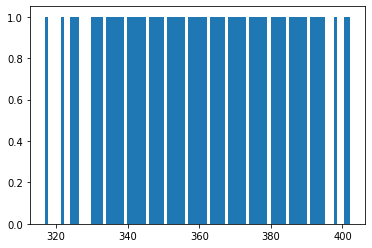

In [101]:
plt.hist(data['stats']['bucket_counts'], bins=100)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([3.  , 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1 ,
        3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.2 , 3.21,
        3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3 , 3.31, 3.32,
        3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4 , 3.41, 3.42, 3.43,
        3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 , 3.51, 3.52, 3.53, 3.54,
        3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.61, 3.62, 3.63, 3.64, 3.65,
        3.66, 3.67, 3.68, 3.69, 3.7 , 3.71, 3.72, 3.73, 3.74, 3.75, 3.76,
        3.77, 3.78, 3.79, 3.8 , 

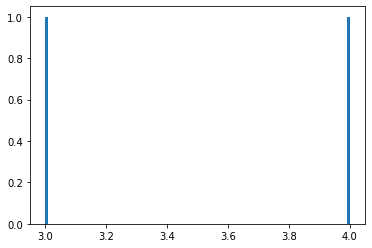

In [102]:
plt.hist(data['stats']['depth_counts'], bins=100)

(array([1., 0., 0., 0., 1., 0., 0., 1., 2., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
        1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

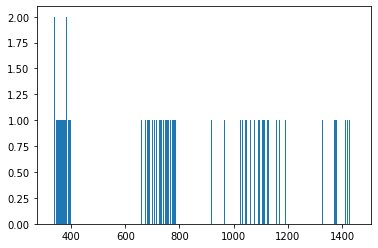

In [113]:
plt.hist(data['stats']['or_op_counts'], bins=1000)

(array([ 3.,  3.,  3.,  3.,  3.,  1.,  3.,  2.,  2.,  2.,  1.,  2.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  3.,  3.,
         3.,  4.,  4.,  4.,  3.,  4.,  4.,  4.,  3.,  4.,  3.,  4.,  3.,
         3.,  3.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  5.,  5.,  6.,  6.,  5.,
         6.,  5.,  6.,  4.,  2.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  6., 12., 11., 11., 11.,  9.]),
 array([   5.  ,   16.22,   27.44,   38.66,   49.88,   61.1 ,   72.32,
          83.54,   94.76,  105.98,  117.2 ,  128.42,  139.64,  150.86,
         162.08,  173.3 ,  184.52,  195.74,  206.96,  218.18,  229.4 ,
         240.62,  251.84,  263.06,  274.28,  285.5 ,  296.72,  307.94,
         319.16,  330.38,  341.6 ,  352.82,  364.04,  375.26,  386.48,
         397.7 ,  408.92,  420.14,  431.36,  442.58,  453.8 ,  465.02,
        

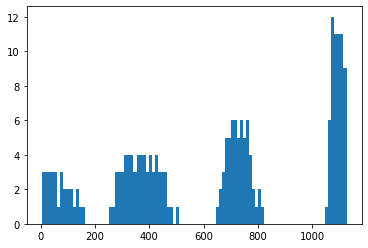

In [90]:
plt.hist(data['stats']['and_op_counts'], bins=100)

In [546]:
# testing cell
gt_ks_idx = [None] * 100
while len(gt_ks_idx) > 30:
    num_attributes=4; num_attr_vals=3;
    bucket_probs = derive_shatter_bucket_probs(num_attr_vals**num_attributes)
    gt_ks_idx, bucket = sample_keys_column(num_attributes, num_attr_vals, bucket_probs)

print('gt_ks_idx', gt_ks_idx)
print('bucket', bucket)
assert len(gt_ks_idx) == bucket

gt_ks_idx [39, 31, 37, 0, 69, 1, 65, 14, 5, 22, 77, 52, 33, 26, 54, 8, 21, 75, 50, 29, 78, 46, 13, 9, 17, 38, 6, 64, 66, 67]
bucket 30


In [122]:
import time

num_attr_vals=3;


for num_attributes in [8]:
    
    start_time = time.time()

    cardpair_answer_lookup = construct_cardpair_answer_lookup(num_attributes, num_attr_vals)

    base_vocab_size = num_attributes * num_attr_vals
    symbol_vocab_token_lookup = {
        '(': base_vocab_size,
        ')': base_vocab_size + 1,
        'NULL': base_vocab_size + 2,
        'SEP': base_vocab_size + 3,
        'SOS': base_vocab_size + 4,
        'EOS': base_vocab_size + 5,
        'PAD': base_vocab_size + 6,
        'PLH': base_vocab_size + 7,
        '&': base_vocab_size + 8,
        '|': base_vocab_size + 9,
    }
    
    bucket_probs = derive_shatter_bucket_probs(num_attr_vals**num_attributes)
    
    num_ORs = []
    num_ANDs = []
    gt_keys_count = []
    
    for _ in range(100):
        gt_ks_idx, bucket = sample_keys_column(num_attributes, num_attr_vals, bucket_probs)

#         num_cards_per_query = (
#             num_keys * query_length_multiplier if query_length_multiplier 
#             else np.random.choice(a==[1,2,3,4,5])
#         )
        num_cards_per_query=(num_attr_vals**num_attributes)*np.random.choice(a=[1,2,3,4,5])
        
        query_for_input_vocab_tokens, num_or_ops, num_and_ops, depth = sample_query_based_on_gt_keys(
            num_attributes, num_attr_vals, num_cards_per_query=num_cards_per_query, nest_depth=16, 
            gt_keys_idx=gt_ks_idx, multiple_OR_sets_bool=True,
            expression_resolve_fn=resolve_eval_expression, cardpair_answer_lookup=cardpair_answer_lookup,
            symbol_vocab_token_lookup=symbol_vocab_token_lookup,
            debug=False
        )
        
        num_ORs.append(num_or_ops)
        num_ANDs.append(num_and_ops)
        gt_keys_count.append(len(gt_ks_idx))

    end_time = time.time()

    print('Time in seconds:', end_time - start_time)

TypeError: sample_query_based_on_gt_keys() got an unexpected keyword argument 'nest_depth'

In [ ]:
# 8, 3 : 525 seconds to construct lookup

(array([  1.,   0.,   0.,   0.,   0.,   0.,  16.,   0.,   0.,   0.,   0.,
          0.,  82.,   0.,   0.,   0.,   0.,   0., 156.,   0.,   0.,   0.,
          0.,   0.,   0., 236.,   0.,   0.,   0.,   0.,   0., 248.,   0.,
          0.,   0.,   0.,   0., 159.,   0.,   0.,   0.,   0.,   0.,  87.,
          0.,   0.,   0.,   0.,   0.,  15.]),
 array([ 9.  ,  9.16,  9.32,  9.48,  9.64,  9.8 ,  9.96, 10.12, 10.28,
        10.44, 10.6 , 10.76, 10.92, 11.08, 11.24, 11.4 , 11.56, 11.72,
        11.88, 12.04, 12.2 , 12.36, 12.52, 12.68, 12.84, 13.  , 13.16,
        13.32, 13.48, 13.64, 13.8 , 13.96, 14.12, 14.28, 14.44, 14.6 ,
        14.76, 14.92, 15.08, 15.24, 15.4 , 15.56, 15.72, 15.88, 16.04,
        16.2 , 16.36, 16.52, 16.68, 16.84, 17.  ]),
 <BarContainer object of 50 artists>)

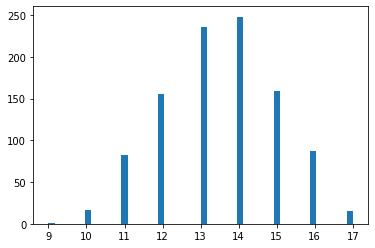

In [217]:
plt.hist(num_ANDs, bins=50)

(array([ 15.,   0.,   0.,   0.,   0.,   0.,  87.,   0.,   0.,   0.,   0.,
          0., 159.,   0.,   0.,   0.,   0.,   0., 248.,   0.,   0.,   0.,
          0.,   0.,   0., 236.,   0.,   0.,   0.,   0.,   0., 156.,   0.,
          0.,   0.,   0.,   0.,  82.,   0.,   0.,   0.,   0.,   0.,  16.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.  , 0.16, 0.32, 0.48, 0.64, 0.8 , 0.96, 1.12, 1.28, 1.44, 1.6 ,
        1.76, 1.92, 2.08, 2.24, 2.4 , 2.56, 2.72, 2.88, 3.04, 3.2 , 3.36,
        3.52, 3.68, 3.84, 4.  , 4.16, 4.32, 4.48, 4.64, 4.8 , 4.96, 5.12,
        5.28, 5.44, 5.6 , 5.76, 5.92, 6.08, 6.24, 6.4 , 6.56, 6.72, 6.88,
        7.04, 7.2 , 7.36, 7.52, 7.68, 7.84, 8.  ]),
 <BarContainer object of 50 artists>)

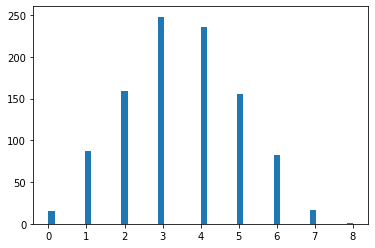

In [216]:
plt.hist(num_ORs, bins=50)

(array([  1.,   0.,   0.,   0.,   0.,   0.,  23.,   0.,   0.,   0.,   0.,
          0.,  73.,   0.,   0.,   0.,   0.,   0., 166.,   0.,   0.,   0.,
          0.,   0.,   0., 259.,   0.,   0.,   0.,   0.,   0., 234.,   0.,
          0.,   0.,   0.,   0., 154.,   0.,   0.,   0.,   0.,   0.,  76.,
          0.,   0.,   0.,   0.,   0.,  14.]),
 array([36.  , 36.16, 36.32, 36.48, 36.64, 36.8 , 36.96, 37.12, 37.28,
        37.44, 37.6 , 37.76, 37.92, 38.08, 38.24, 38.4 , 38.56, 38.72,
        38.88, 39.04, 39.2 , 39.36, 39.52, 39.68, 39.84, 40.  , 40.16,
        40.32, 40.48, 40.64, 40.8 , 40.96, 41.12, 41.28, 41.44, 41.6 ,
        41.76, 41.92, 42.08, 42.24, 42.4 , 42.56, 42.72, 42.88, 43.04,
        43.2 , 43.36, 43.52, 43.68, 43.84, 44.  ]),
 <BarContainer object of 50 artists>)

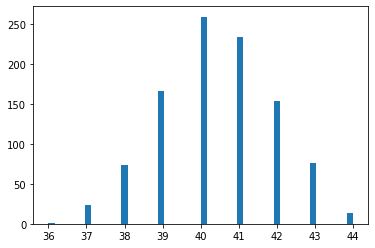

In [225]:
plt.hist(num_ANDs, bins=50)

(array([ 14.,   0.,   0.,   0.,   0.,   0.,  76.,   0.,   0.,   0.,   0.,
          0., 154.,   0.,   0.,   0.,   0.,   0., 234.,   0.,   0.,   0.,
          0.,   0.,   0., 259.,   0.,   0.,   0.,   0.,   0., 166.,   0.,
          0.,   0.,   0.,   0.,  73.,   0.,   0.,   0.,   0.,   0.,  23.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.  , 0.16, 0.32, 0.48, 0.64, 0.8 , 0.96, 1.12, 1.28, 1.44, 1.6 ,
        1.76, 1.92, 2.08, 2.24, 2.4 , 2.56, 2.72, 2.88, 3.04, 3.2 , 3.36,
        3.52, 3.68, 3.84, 4.  , 4.16, 4.32, 4.48, 4.64, 4.8 , 4.96, 5.12,
        5.28, 5.44, 5.6 , 5.76, 5.92, 6.08, 6.24, 6.4 , 6.56, 6.72, 6.88,
        7.04, 7.2 , 7.36, 7.52, 7.68, 7.84, 8.  ]),
 <BarContainer object of 50 artists>)

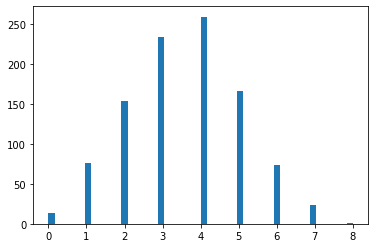

In [226]:
plt.hist(num_ORs, bins=50)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  39.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,  51.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  86.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0., 147.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 150.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 136.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

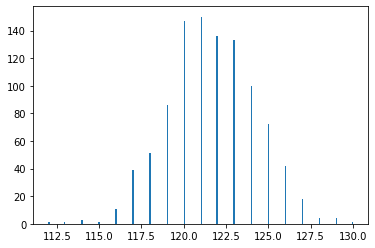

In [233]:
plt.hist(num_ANDs, bins=250)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  18.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         42.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  72.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 133.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0., 136.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 150.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 147.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

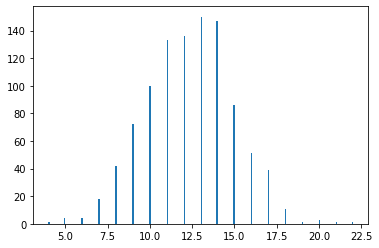

In [234]:
plt.hist(num_ORs, bins=250)

(array([15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0., 37.,
         0.,  2.,  0.,  0.,  0., 25.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0., 35.,  0.,  0.,  0.,  0., 18.,  0.,  0.,  0., 22.,  0.,
         0.,  0.,  0.,  0., 14.,  0., 13.,  0.,  0.,  0.,  6.,  0.,  0.,
         0.,  9.,  0., 21.,  0., 17.,  0.,  0.,  0., 27.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0., 22.,  0., 26.,  0.,  0.,  0.,
        14.,  0.,  0.,  0.,  0.,  0.,  4.,  0., 29.,  0.,  0.,  0.,  0.,
         0.,  5.,  0.,  0., 21.,  0.,  0.,  0., 18.,  0.,  9.,  0.,  2.,
         0., 12.,  0.,  0.,  0.,  0.,  0., 28.,  0.,  0.,  0., 24.,  0.,
         0.,  0.,  5.,  0.,  0.,  0.,  7.,  0.,  0., 18.,  0., 12.,  0.,
         8.,  0.,  0.,  0.,  0.,  0., 36.,  0.,  0.,  0.,  0.,  0.,  1.,
         0., 22.,  0., 13.,  0.,  2.,  0.,  0.,  0., 16.,  0.,  7.,  0.,
         0., 10.,  0.,  0.,  0., 36.,  0.,  0.,  0.,  0.,  0., 15.,  0.,
        10.,  0.,  0.,  0., 12.,  0.,  0.,  0., 11.

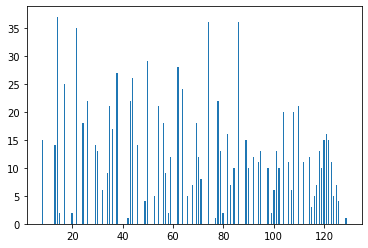

In [236]:
plt.hist(num_ANDs, bins=250)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  7.,  0.,  5.,  0., 11.,
         0., 15.,  0., 16.,  0., 15.,  0., 10.,  0., 13.,  0.,  7.,  0.,
         5.,  0.,  3.,  0., 12.,  0.,  0.,  0.,  0., 11.,  0.,  0.,  0.,
        21.,  0.,  0.,  0., 20.,  0.,  6.,  0., 11.,  0.,  0.,  0., 20.,
         0.,  0.,  0., 10.,  0., 13.,  0.,  6.,  0.,  2.,  0.,  0., 10.,
         0.,  0.,  0.,  0.,  0., 13.,  0., 11.,  0.,  0.,  0., 12.,  0.,
         0.,  0., 10.,  0., 15.,  0.,  0.,  0.,  0.,  0., 36.,  0.,  0.,
         0., 10.,  0.,  0.,  7.,  0., 16.,  0.,  0.,  0.,  2.,  0., 13.,
         0., 22.,  0.,  1.,  0.,  0.,  0.,  0.,  0., 36.,  0.,  0.,  0.,
         0.,  0.,  8.,  0., 12.,  0., 18.,  0.,  0.,  7.,  0.,  0.,  0.,
         5.,  0.,  0.,  0., 24.,  0.,  0.,  0., 28.,  0.,  0.,  0.,  0.,
         0., 12.,  0.,  2.,  0.,  9.,  0., 18.,  0.,  0.,  0., 21.,  0.,
         0.,  5.,  0.,  0.,  0.,  0.,  0., 29.,  0.,  4.,  0.,  0.,  0.,
         0.,  0., 14.,  0.,  0.,  0., 26.,  0., 22.

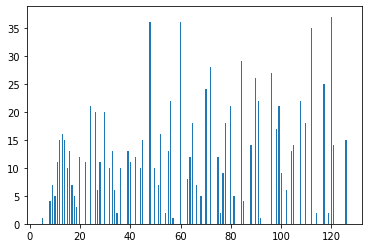

In [237]:
plt.hist(num_ORs, bins=250)

(array([23.,  0.,  0.,  0., 15.,  0., 18.,  0., 16.,  0.,  2.,  0., 26.,
         0., 16.,  0., 17.,  0., 42.,  0., 26.,  0., 44.,  0., 35.,  0.,
        27.,  0., 19.,  0., 37.,  0.,  0.,  6.,  0.,  5.,  0., 14.,  0.,
         6.,  0.,  4.,  0., 14.,  0., 12.,  0., 17.,  0., 11.,  0., 13.,
         0.,  3.,  0., 19.,  0.,  8.,  0.,  4.,  0., 16.,  0.,  0.,  6.,
         0.,  1.,  0., 15.,  0., 11.,  0., 17.,  0., 19.,  0.,  8.,  0.,
        16.,  0., 13.,  0., 10.,  0.,  9.,  0., 27.,  0.,  0.,  0.,  5.,
         0.,  9.,  0.,  0.,  4.,  0.,  1.,  0., 16.,  0.,  4.,  0.,  5.,
         0.,  7.,  0.,  8.,  0.,  4.,  0.,  9.,  0.,  8.,  0.,  2.,  0.,
        11.,  0.,  2.,  0.,  0.,  0.,  8.,  0.,  0.,  7.,  0., 11.,  0.,
        10.,  0.,  6.,  0.,  9.,  0., 10.,  0.,  8.,  0.,  3.,  0., 14.,
         0.,  0.,  0.,  0.,  0., 11.,  0.,  5.,  0.,  0.,  0.,  4.,  0.,
         0.,  5.,  0.,  9.,  0.,  3.,  0.,  7.,  0.,  4.,  0.,  2.,  0.,
         1.,  0.,  5.,  0.,  7.,  0.,  2.,  0.,  0.

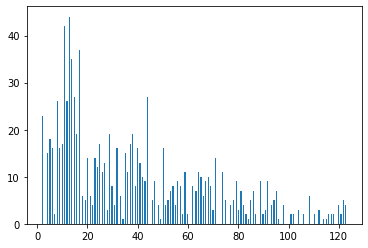

In [254]:
plt.hist(num_ANDs, bins=250)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  5.,  0., 15.,  0., 15.,  0., 31.,
         0., 39.,  0., 57.,  0., 43.,  0., 46.,  0., 24.,  0., 12.,  0.,
        17.,  0.,  3.,  0., 27.,  0.,  0.,  3.,  0., 28.,  0.,  0.,  0.,
        36.,  0.,  0.,  0., 26.,  0.,  4.,  0., 23.,  0.,  0.,  0., 24.,
         0.,  0.,  0., 16.,  0., 17.,  0.,  5.,  0.,  1.,  0.,  0., 37.,
         0.,  0.,  0.,  0.,  0., 18.,  0., 17.,  0.,  0.,  0., 23.,  0.,
         0.,  0., 20.,  0., 20.,  0.,  0.,  0.,  0.,  0., 36.,  0.,  1.,
         0.,  5.,  0.,  0.,  6.,  0., 11.,  0.,  0.,  0., 10.,  0., 10.,
         0., 17.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 19.,  0.,  0.,  0.,
         0.,  0.,  4.,  0.,  6.,  0., 19.,  0.,  0.,  5.,  0.,  0.,  0.,
         5.,  0.,  0.,  0., 26.,  0.,  0.,  0., 15.,  0.,  0.,  0.,  0.,
         0., 12.,  0.,  0.,  0.,  8.,  0.,  9.,  0.,  0.,  0.,  8.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  0., 13.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  5.,  0.,  0.,  0., 21.,  0., 10.

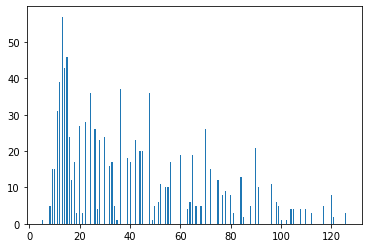

In [255]:
plt.hist(num_ORs, bins=250)

In [ ]:
# Get Stats
# get timing stats with num attrs, query length and nesting depth
# get distribution stats with num gt keys, num or and num and

In [ ]:
# for large scale, run validation code again
# for small scale, try hand derive

In [149]:
# num_attributes=2; num_attr_vals=3; nest_depth = 2; num_cards multiple 1
16000000 / 1000 * 0.1692032814025879 / 3600

0.7520145840115018

In [147]:
# num_attributes=3; num_attr_vals=3; nest_depth = 2; num_cards multiple 1
16000000 / 1000 * 0.31555628776550293 / 3600

1.402472390068902

In [145]:
# num_attributes=4; num_attr_vals=3; nest_depth = 2; num_cards multiple 1
16000000 / 1000 * 0.7429971694946289 / 3600

3.302209642198351

In [143]:
# num_attributes=5; num_attr_vals=3; nest_depth = 2; num_cards multiple 1
16000000 / 1000 * 3.189704418182373 / 3600

14.176464080810547

In [151]:
# num_attributes=6; num_attr_vals=3; nest_depth = 2; num_cards multiple 1
16000000 / 1000 * 22.876854181289673 / 3600

101.67490747239854

In [149]:
# num_attributes=2; num_attr_vals=3; nest_depth = 4; num_cards multiple 1
16000000 / 1000 * 0.1772172451019287 / 3600

0.7520145840115018

In [156]:
# num_attributes=3; num_attr_vals=3; nest_depth = 4; num_cards multiple 1
16000000 / 1000 * 0.3295173645019531 / 3600

1.4645216200086806

In [158]:
# num_attributes=4; num_attr_vals=3; nest_depth = 4; num_cards multiple 1
16000000 / 1000 * 0.7104599475860596 / 3600

3.157599767049154

In [160]:
# num_attributes=5; num_attr_vals=3; nest_depth = 4; num_cards multiple 1
16000000 / 1000 * 2.511939525604248 / 3600

11.164175669352213

In [162]:
# num_attributes=6; num_attr_vals=3; nest_depth = 4; num_cards multiple 1
16000000 / 1000 * 13.737230777740479 / 3600

61.0543590121799

In [173]:
# num_attributes=2; num_attr_vals=3; nest_depth = 4; num_cards multiple 2
16000000 / 1000 * 0.2624199390411377 / 3600

1.1663108401828342

In [171]:
# num_attributes=3; num_attr_vals=3; nest_depth = 4; num_cards multiple 2
16000000 / 1000 * 0.5335986614227295 / 3600

2.371549606323242

In [169]:
# num_attributes=4; num_attr_vals=3; nest_depth = 4; num_cards multiple 2
16000000 / 1000 * 1.32326340675354 / 3600

5.8811706966824

In [167]:
# num_attributes=5; num_attr_vals=3; nest_depth = 4; num_cards multiple 2
16000000 / 1000 * 4.917572021484375 / 3600

21.855875651041668

In [165]:
# num_attributes=6; num_attr_vals=3; nest_depth = 4; num_cards multiple 2
16000000 / 1000 * 26.512848615646362 / 3600

117.83488273620605

In [176]:
# num_attributes=5; num_attr_vals=3; nest_depth = 8; num_cards multiple 2
16000000 / 1000 * 4.424482583999634 / 3600

19.66436703999837

In [181]:
# num_attributes=6; num_attr_vals=3; nest_depth = 8; num_cards multiple 2
16000000 / 1000 * 18.38077664375305 / 3600

81.69234063890245

In [178]:
# num_attributes=6; num_attr_vals=3; nest_depth = 8; num_cards multiple 8
16000000 / 1000 * 60.408149003982544 / 3600 # 11.186694259996768 days

268.4806622399224

In [245]:
# num_attributes=5; num_attr_vals=3; nest_depth = 16; num_cards multiple 8
16000000 / 1000 * 17.187467575073242 / 3600

76.3887447781033

In [187]:
# num_attributes=6; num_attr_vals=3; nest_depth = 16; num_cards multiple 8
16000000 / 1000 * 61.988829374313354 / 3600

275.50590833028156

In [ ]:
# Testing
    # - by example
        # - pull intermediate outputs for a few examples
            # short
            # long
                # pull intermediate outputs.
                # pull DERIVE, check if eval expression indeed eval to ans. Try hand and previously written functions.
        
        # check if eval expression indeed eval to ans by PROPERTIES. Try hand and previously written functions.l 

    # - by statistics
        # - are query lengths, gt_key_idx lengths, num_or and num_and ops balanced. Pull some stats for presentations